In [1]:
# --- Plotting smooth arcs + coverage --------------------------------------
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT      = Path("..")  # run from emobook/notebooks/
SCORE_DIR = ROOT / "scored_v21"

def _odd(n):  # make rolling window odd for center=True
    n = int(round(n))
    return n if n % 2 == 1 else max(1, n-1)

def load_scored(book_stem: str):
    f = SCORE_DIR / f"{book_stem}.scored_v21.csv"
    df = pd.read_csv(f)
    df = df.sort_values("chunk_id").reset_index(drop=True)
    return df

def add_rolls(df: pd.DataFrame, win=None, frac=0.01):
    if win is None:
        win = _odd(max(5, int(len(df) * frac)))
    df = df.copy()
    for col in ["v","a","d","coverage"]:
        df[f"{col}_roll"] = df[col].rolling(win, center=True, min_periods=1).mean()
    return df, win

def plot_series(df: pd.DataFrame, yraw: str, yroll: str, title: str):
    plt.figure(figsize=(10, 3))
    plt.plot(df["chunk_id"], df[yraw], linewidth=0.8, alpha=0.4, label=f"{yraw} (raw)")
    plt.plot(df["chunk_id"], df[yroll], linewidth=1.6, label=f"{yroll} (roll)")
    plt.title(title)
    plt.xlabel("chunk")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

def plot_book_arcs(book_stem: str, win=None, frac=0.01):
    df = load_scored(book_stem)
    df, win = add_rolls(df, win=win, frac=frac)
    print(f"{book_stem}: n={len(df)}  rolling_window={win}  avg_coverage={df['coverage'].mean():.3f}")

    # Valence
    plot_series(df, "v", "v_roll", f"{book_stem} — Valence ([-1,1])")
    # Arousal
    plot_series(df, "a", "a_roll", f"{book_stem} — Arousal ([-1,1])")
    # Dominance
    plot_series(df, "d", "d_roll", f"{book_stem} — Dominance ([-1,1])")
    # Coverage
    plot_series(df, "coverage", "coverage_roll", f"{book_stem} — Lexicon Coverage")

# EXAMPLES (uncomment what you want to view)
# plot_book_arcs("Frankenstein.clean")
# plot_book_arcs("Mobi Dick.clean")
# plot_book_arcs("Pride and Prejudice.clean")
# plot_book_arcs("Romeo and Juliet.clean")
# plot_book_arcs("The Adventures of Sherlock Holmes.clean")


Frankenstein.clean: n=1559  rolling_window=15  avg_coverage=0.687


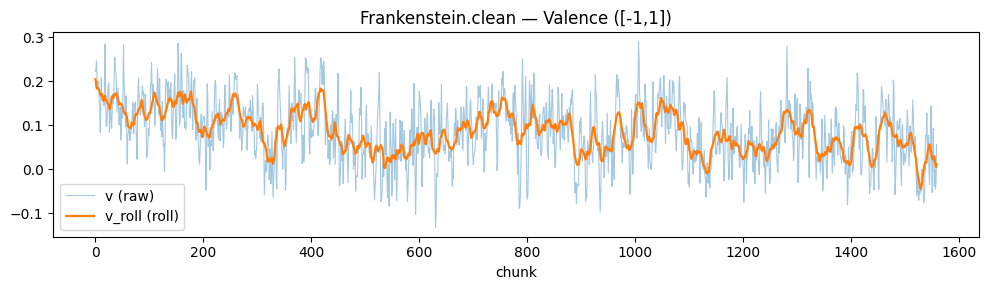

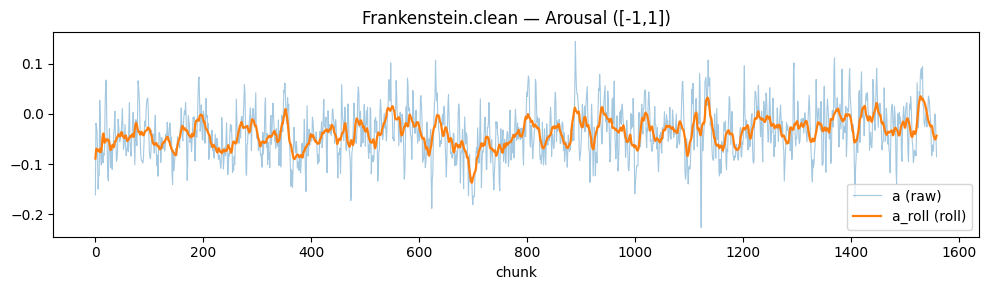

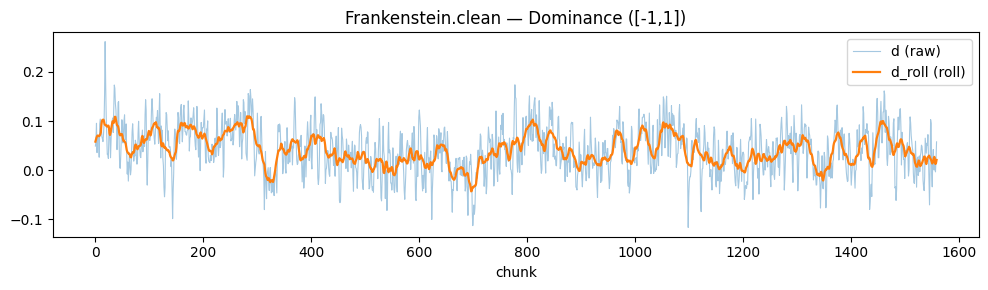

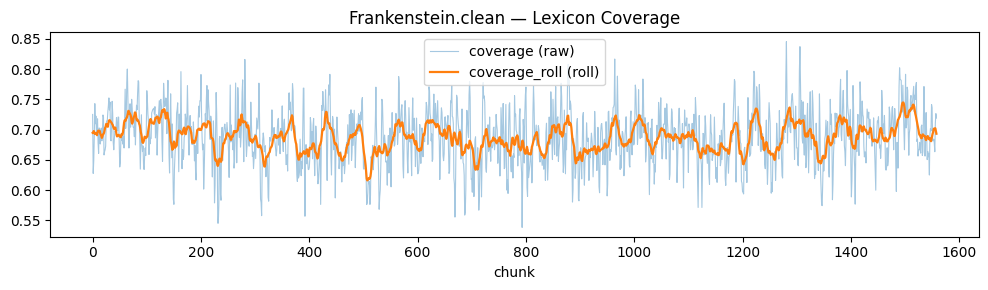

In [2]:
plot_book_arcs("Frankenstein.clean")

In [9]:
# --- Diagnostics for deciding V-only vs VAD -------------------------------
from pathlib import Path
import pandas as pd
import numpy as np

ROOT      = Path("..")
SCORE_DIR = ROOT / "scored_v21"

def summarize_arcs(book_stem: str, win=None, frac=0.01):
    f = SCORE_DIR / f"{book_stem}.scored_v21.csv"
    df = pd.read_csv(f).sort_values("chunk_id").reset_index(drop=True)
    n = len(df)
    if win is None:
        win = int(round(max(5, n * frac)))
        if win % 2 == 0: win -= 1

    sm = df[["v","a","d","coverage"]].rolling(win, center=True, min_periods=1).mean()
    sm.columns = [c+"_roll" for c in sm.columns]
    df = pd.concat([df, sm], axis=1)

    def dyn_range(x):
        return float(np.nanpercentile(x, 95) - np.nanpercentile(x, 5))

    # smoothness proxy = negative variance of first differences (smaller is smoother)
    def smoothness(x):
        d = np.diff(np.nan_to_num(x, nan=np.nanmean(x)))
        return -float(np.nanvar(d))

    out = {
        "book": book_stem,
        "n_chunks": n,
        "avg_coverage": float(df["coverage"].mean()),
        "V_range": dyn_range(df["v_roll"]),
        "A_range": dyn_range(df["a_roll"]),
        "D_range": dyn_range(df["d_roll"]),
        "V_smooth": smoothness(df["v_roll"]),
        "A_smooth": smoothness(df["a_roll"]),
        "D_smooth": smoothness(df["d_roll"]),
        "VAD_var_explained": float(np.nanvar(df[["v_roll","a_roll","d_roll"]].values, ddof=1).mean()),
        "corr_V_A": float(np.corrcoef(df["v_roll"], df["a_roll"])[0,1]),
        "corr_V_D": float(np.corrcoef(df["v_roll"], df["d_roll"])[0,1]),
    }
    return out, df

def compare_v_vs_vad(book_stem: str, win=None, frac=0.01):
    stats, df = summarize_arcs(book_stem, win=win, frac=frac)
    s = pd.Series(stats)
    display(s.to_frame("value"))

    # light, interpretable verdict:
    verdict = []
    if s["A_range"] > 0.15 or s["D_range"] > 0.15:
        verdict.append("VAD adds signal (A/D dynamic range is sizable).")
    else:
        verdict.append("A/D vary little; Valence alone likely sufficient.")

    if abs(s["corr_V_A"]) < 0.6 or abs(s["corr_V_D"]) < 0.6:
        verdict.append("V is not tightly coupled to A/D → multidimensional view helpful.")
    else:
        verdict.append("V is strongly correlated with A/D → similar story either way.")

    if s["avg_coverage"] < 0.35:
        verdict.append("Low coverage: consider larger chunks or alternate lexicon.")
    elif s["avg_coverage"] > 0.65:
        verdict.append("Good coverage across chunks.")
    else:
        verdict.append("Moderate coverage; OK but could be improved.")

    print("\n— Quick take —")
    for v in verdict:
        print("•", v)

# EXAMPLES (run one at a time)
#compare_v_vs_vad("Frankenstein.clean")
#compare_v_vs_vad("Mobi Dick.clean")
#compare_v_vs_vad("Pride and Prejudice.clean")
#compare_v_vs_vad("Romeo and Juliet.clean")
compare_v_vs_vad("The Adventures of Sherlock Holmes.clean")


,value
book,The Adventures of Sherlock Holmes.clean
n_chunks,2168
avg_coverage,0.697337
V_range,0.087045
A_range,0.057568
D_range,0.077602
V_smooth,-0.000012
A_smooth,-0.000008
D_smooth,-0.000009
VAD_var_explained,0.005425



— Quick take —
• A/D vary little; Valence alone likely sufficient.
• V is not tightly coupled to A/D → multidimensional view helpful.
• Good coverage across chunks.


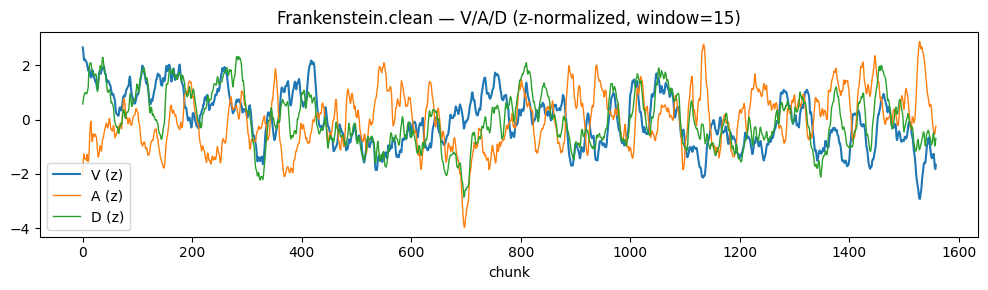

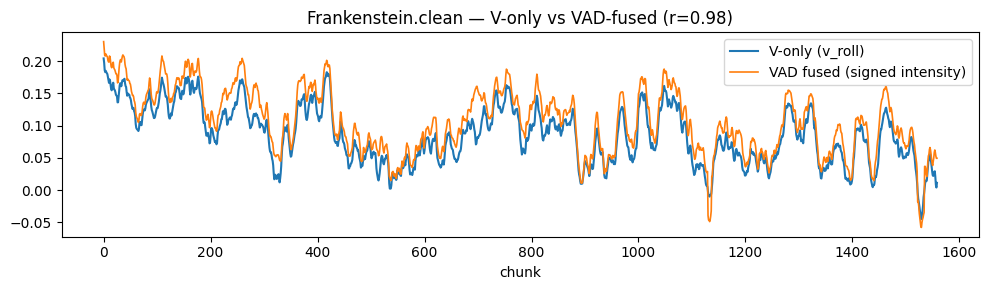

Top 3 disagreement chunks: [697, 696, 698]


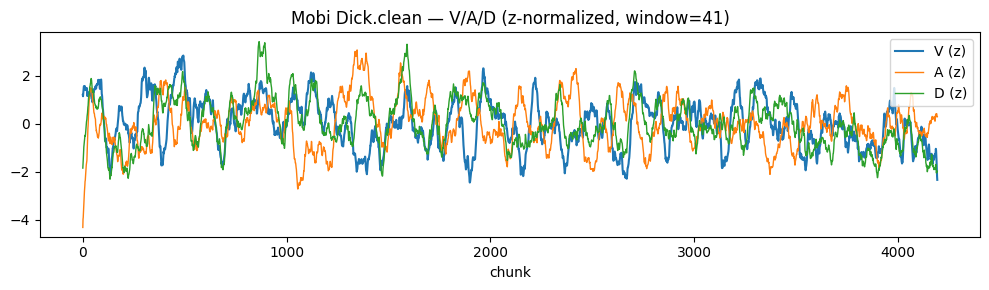

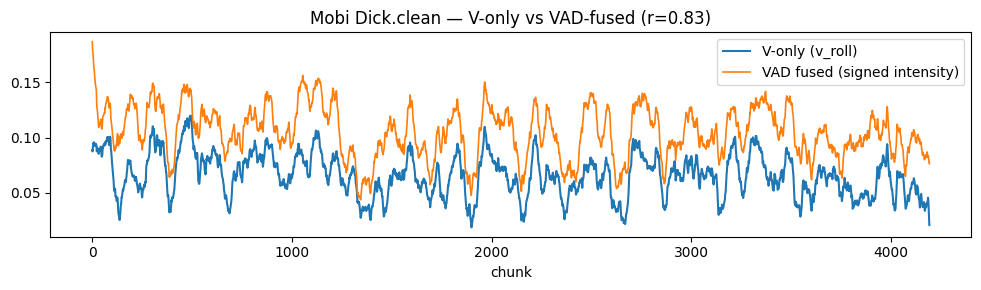

Top 3 disagreement chunks: [0, 1, 2]


In [10]:
# --- Combined views: overlay & fused VAD vs V-only ------------------------
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

ROOT      = Path("..")
SCORE_DIR = ROOT / "scored_v21"

def load_scored_sorted(book_stem):
    df = pd.read_csv(SCORE_DIR / f"{book_stem}.scored_v21.csv").sort_values("chunk_id")
    return df.reset_index(drop=True)

def rolling_centered(df, cols=("v","a","d","coverage"), win=None):
    if win is None:
        win = max(5, int(round(len(df)*0.01)))
        if win % 2 == 0: win -= 1
    sm = df.loc[:, cols].rolling(win, center=True, min_periods=1).mean()
    sm.columns = [c+"_roll" for c in cols]
    return pd.concat([df, sm], axis=1), win

def zscore(x):
    mu, sd = np.nanmean(x), np.nanstd(x) + 1e-9
    return (x - mu) / sd

def plot_overlay_normalized(book_stem, win=None):
    df, win = rolling_centered(load_scored_sorted(book_stem), ("v","a","d","coverage"), win=win)
    zr = pd.DataFrame({
        "chunk_id": df["chunk_id"],
        "Vz": zscore(df["v_roll"]),
        "Az": zscore(df["a_roll"]),
        "Dz": zscore(df["d_roll"])
    })
    plt.figure(figsize=(10,3))
    plt.plot(zr["chunk_id"], zr["Vz"], linewidth=1.5, label="V (z)")
    plt.plot(zr["chunk_id"], zr["Az"], linewidth=1.0, label="A (z)")
    plt.plot(zr["chunk_id"], zr["Dz"], linewidth=1.0, label="D (z)")
    plt.title(f"{book_stem} — V/A/D (z-normalized, window={win})")
    plt.xlabel("chunk"); plt.legend(); plt.tight_layout(); plt.show()

def plot_v_vs_vad_fused(book_stem, win=None):
    df, win = rolling_centered(load_scored_sorted(book_stem), ("v","a","d","coverage"), win=win)
    vad_signed = np.sign(df["v_roll"]) * np.sqrt(df["v_roll"]**2 + df["a_roll"]**2 + df["d_roll"]**2)
    corr = np.corrcoef(df["v_roll"].fillna(0), vad_signed.fillna(0))[0,1]
    plt.figure(figsize=(10,3))
    plt.plot(df["chunk_id"], df["v_roll"], linewidth=1.5, label="V-only (v_roll)")
    plt.plot(df["chunk_id"], vad_signed, linewidth=1.2, label="VAD fused (signed intensity)")
    plt.title(f"{book_stem} — V-only vs VAD-fused (r={corr:.2f})")
    plt.xlabel("chunk"); plt.legend(); plt.tight_layout(); plt.show()
    return df, vad_signed, corr

def top_disagreements(book_stem, k=5, win=None):
    df, vad_signed, _ = plot_v_vs_vad_fused(book_stem, win=win)
    diff = (vad_signed - df["v_roll"]).abs()
    idx = diff.nlargest(k).index.tolist()
    print(f"Top {k} disagreement chunks: {idx}")
    return df.loc[idx, ["chunk_id","text","v_roll"]].assign(vad_fused=vad_signed.iloc[idx].values)

# EXAMPLES:
plot_overlay_normalized("Frankenstein.clean")
_ = top_disagreements("Frankenstein.clean", k=3)
plot_overlay_normalized("Mobi Dick.clean"); _ = top_disagreements("Mobi Dick.clean", k=3)


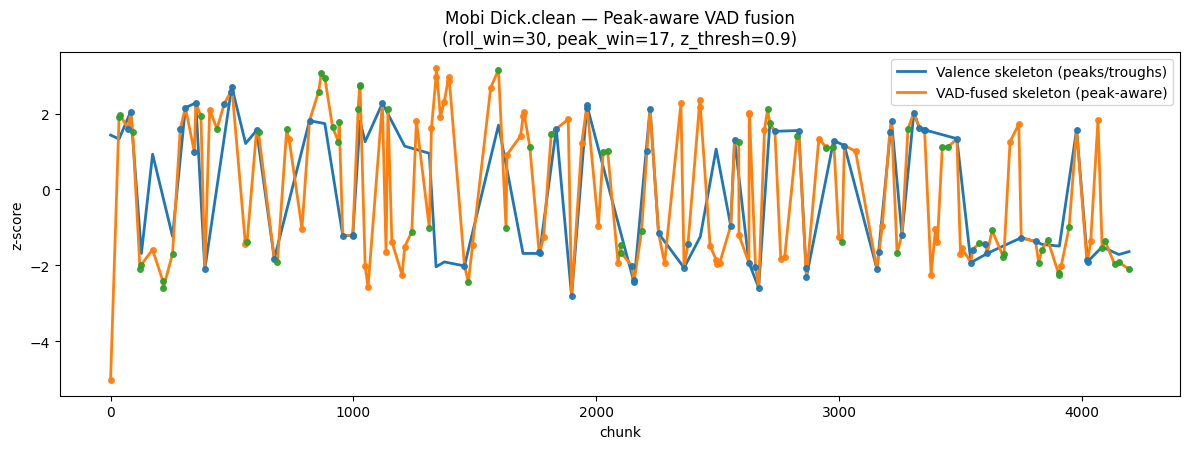

In [20]:
# --- Peak-aware VAD fusion: crest/trough skeletons ------------------------
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

ROOT      = Path("..")
SCORE_DIR = ROOT / "scored_v21"

def load_scored_sorted(book_stem):
    df = pd.read_csv(SCORE_DIR / f"{book_stem}.scored_v21.csv").sort_values("chunk_id")
    return df.reset_index(drop=True)

def rolling_centered(df, cols=("v","a","d"), win=None, frac=0.01):
    if win is None:
        win = max(5, int(round(len(df)*frac)))
        if win % 2 == 0: win -= 1
    sm = df.loc[:, cols].rolling(win, center=True, min_periods=1).mean()
    sm.columns = [c+"_roll" for c in cols]
    return pd.concat([df, sm], axis=1), win

def zscore(x):
    mu, sd = np.nanmean(x), np.nanstd(x) + 1e-9
    return (x - mu) / sd

def find_extrema(z, win=11, z_thresh=0.8):
    """
    Simple peak/trough detector:
      - local max over ±win neighborhood and above +z_thresh
      - local min over ±win neighborhood and below -z_thresh
    Returns sorted indices of both peaks & troughs (signed kept in values).
    """
    n = len(z); idx = set()
    for i in range(win, n-win):
        seg = z[i-win:i+win+1]
        if z[i] == np.max(seg) and z[i] >= z_thresh:
            idx.add(i)
        elif z[i] == np.min(seg) and z[i] <= -z_thresh:
            idx.add(i)
    # always anchor start/end so the skeleton spans whole book
    idx.update({0, n-1})
    return sorted(idx)


def skeletonize(x, key_idxs):
    """
    Piecewise-linear 'skeleton' through (key_idx, x[key_idx]) points.
    Safe if key_idxs has 0 or 1 element.
    """
    n = len(x)
    key_idxs = sorted({i for i in key_idxs if 0 <= i < n})
    if len(key_idxs) == 0:
        return np.zeros(n, dtype=float)
    if len(key_idxs) == 1:
        return np.full(n, float(x[key_idxs[0]]), dtype=float)
    return np.interp(np.arange(n), key_idxs, [float(x[i]) for i in key_idxs])

def peak_fusion_plot(book_stem, roll_win=None, peak_win=11, z_thresh=0.8, show_overlay=False):
    """
    Peak-aware fusion with robust skeletonization.
    """
    df = load_scored_sorted(book_stem)
    df, roll_win = rolling_centered(df, cols=("v","a","d"), win=roll_win)

    Vz = zscore(df["v_roll"].values)
    Az = zscore(df["a_roll"].values)
    Dz = zscore(df["d_roll"].values)
    x  = df["chunk_id"].values
    n  = len(df)

    # turning points per dim (always anchor ends)
    v_tp = find_extrema(Vz, win=peak_win, z_thresh=z_thresh)
    a_tp = find_extrema(Az, win=peak_win, z_thresh=z_thresh)
    d_tp = find_extrema(Dz, win=peak_win, z_thresh=z_thresh)
    fused_tp = sorted(set(v_tp) | set(a_tp) | set(d_tp) | {0, n-1})

    # value at each fused TP = strongest |z| among V/A/D at that index
    fused_vals = []
    for i in fused_tp:
        vec = np.array([Vz[i], Az[i], Dz[i]])
        j   = int(np.argmax(np.abs(vec)))  # 0=V,1=A,2=D
        fused_vals.append(vec[j])

    # build skeletons (no empty calls)
    v_skel = skeletonize(Vz, v_tp)

    # create a sparse series with values only at fused TPs, then interpolate
    temp = np.full(n, np.nan, dtype=float)
    for i, val in zip(fused_tp, fused_vals):
        temp[i] = float(val)
    # ensure both ends are set (should already be)
    if np.isnan(temp[0]):  temp[0]  = Vz[0]
    if np.isnan(temp[-1]): temp[-1] = Vz[-1]
    notnan = np.where(~np.isnan(temp))[0]
    if len(notnan) < 2:
        fused_skel = np.zeros(n, dtype=float)
    else:
        fused_skel = np.interp(np.arange(n), notnan, temp[notnan])

    # which dim dominated each fused TP (for colored dots)
    fused_dim = []
    for i in fused_tp:
        vec = np.array([Vz[i], Az[i], Dz[i]])
        fused_dim.append(["V","A","D"][int(np.argmax(np.abs(vec)))])

    # --- plot
    plt.figure(figsize=(12, 4.6))
    if show_overlay:
        plt.plot(x, Vz, alpha=0.25, linewidth=0.8, label="V (z) raw")
        plt.plot(x, Az, alpha=0.25, linewidth=0.8, label="A (z) raw")
        plt.plot(x, Dz, alpha=0.25, linewidth=0.8, label="D (z) raw")

    plt.plot(x, v_skel,     linewidth=2.0, label="Valence skeleton (peaks/troughs)")
    plt.plot(x, fused_skel, linewidth=2.0, label="VAD-fused skeleton (peak-aware)")

    color = {"V":"C0","A":"C1","D":"C2"}
    for i, dim in zip(fused_tp, fused_dim):
        plt.scatter(x[i], fused_skel[i], s=16, c=color[dim], alpha=0.9, zorder=5)

    plt.title(f"{book_stem} — Peak-aware VAD fusion\n"
              f"(roll_win={roll_win}, peak_win={peak_win}, z_thresh={z_thresh})")
    plt.xlabel("chunk"); plt.ylabel("z-score"); plt.legend(loc="best")
    plt.tight_layout(); plt.show()

    return {
        "x": x, "Vz": Vz, "Az": Az, "Dz": Dz,
        "v_skeleton": v_skel,
        "vad_fused_skeleton": fused_skel,
        "v_turns": v_tp, "fused_turns": fused_tp, "fused_dims": fused_dim
    }




# EXAMPLES:
#_ = peak_fusion_plot("Frankenstein.clean", roll_win=15, peak_win=15, z_thresh=0.8)
_ = peak_fusion_plot("Mobi Dick.clean",   roll_win=30, peak_win=17, z_thresh=0.9)


In [17]:
plt.plot(x, fused_skel, linewidth=2.0, label="VAD-fused skeleton (peak-aware)")

NameError: name 'x' is not defined